In [1]:
import anndata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

In [2]:
ad = anndata.read_h5ad('/home/yuanh/sc_basset/Buenrostro_2018/sc_peakset/raw/ad.h5ad')

### find the topic that best correlate with batch and remove it

In [3]:
topics = pd.read_csv('../projection.csv', index_col=0).values

In [4]:
ad.obsm['projection'] = topics
sc.pp.neighbors(ad, use_rep='projection')
sc.tl.tsne(ad, use_rep='projection')

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [4]:
batch_code = pd.get_dummies(ad.obs['batch'])['BM0828']
aucs = []
for i in range(topics.shape[1]):
    a = roc_auc_score(batch_code, topics[:,i])
    b = roc_auc_score(1-batch_code, topics[:,i])
    aucs +=[np.max([a,b])]
indices = np.argsort(aucs)[::-1]

In [ ]:
f, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 9))
for i in range(12):
    var_name = 'topic_%d'%indices[i]
    ad.obs[var_name] = topics[:,indices[i]]
    row = int(i/4)
    col = i%4
    sc.pl.tsne(ad, color=var_name, ax=axs[row][col], show=False)
f.tight_layout()
f.savefig('select_batch_topic.pdf')

### plot batch corrected t-SNE

In [ ]:
f, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 9))
for i in range(12):
    select = np.isin(np.arange(40), indices[:(i+1)])
    topics_new = topics[:, ~select]
    ad.obsm['projection'] = topics_new
    sc.pp.neighbors(ad, use_rep='projection')
    sc.tl.tsne(ad, use_rep='projection')
    row = int(i/4)
    col = i%4
    sc.pl.tsne(ad, color='label', ax=axs[row][col], show=False)
    axs[row][col].set_title('exclude top %d topics' %(i+1))
f.tight_layout()
f.savefig('select_batch_tsne.pdf')

### save batch corrected embeddings

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


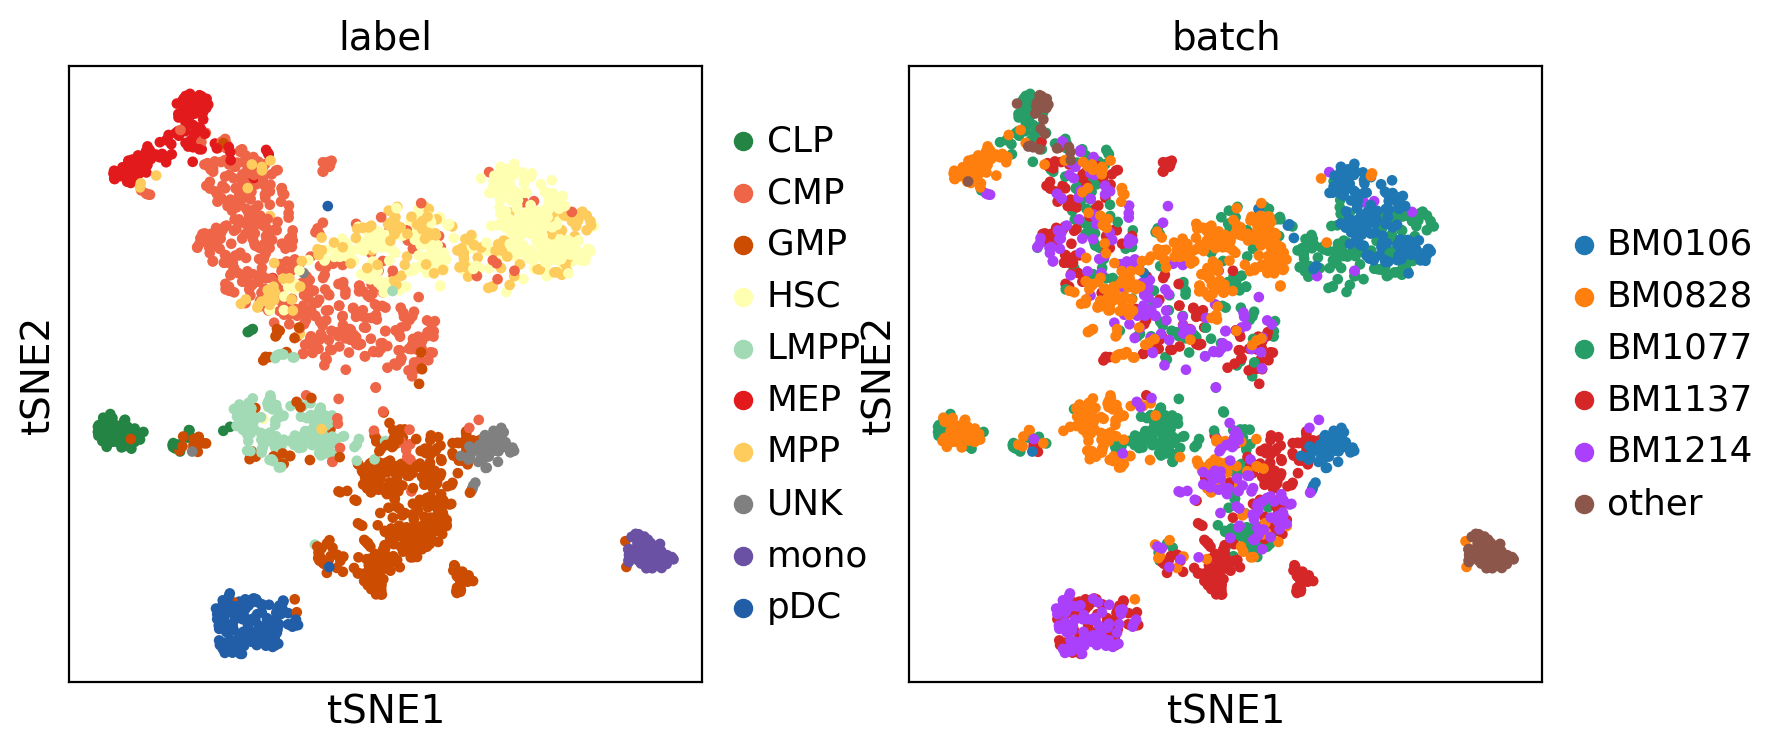

In [5]:
i = 7
select = np.isin(np.arange(40), indices[:(i+1)])
topics_new = topics[:, ~select]
pd.DataFrame(topics_new).to_csv('projection_bc.csv')

sc.set_figure_params(vector_friendly=True, format='pdf', dpi=100)
ad.obsm['projection'] = topics_new
sc.pp.neighbors(ad, use_rep='projection')
sc.tl.tsne(ad, use_rep='projection')
f = sc.pl.tsne(ad, color=['label', 'batch'], return_fig=True)
f.savefig('tsne_bc.pdf')